## Principal Component Analysis

Importing necessary libraries and reading training data:

In [3]:
import numpy as np
import view.visualize as v
import utils.utils as utils

path_data="data/part2/iris.txt"

data=utils.read_data_from_txt(path_data,dim=(-1,5),delimiter=",")


Extracting features and labels from the data set:

In [4]:
# extract feature data
X=data[:,:4]
# extract labels
Y=data[:,4]

To standardize the results, the data has to be centered around the mean by computing the mean of the data and subtracting the data from the computed mean:

In [17]:
def normalize_data(X):
    """
    To normalize results, computing centered mean of input data with unit variance by subtracting X from its mean across the features
    and dividing by standard deviation of X

    :param X: data input
    :return: normalized data
    """
    # centering
    X_center = X - np.mean(X, axis=0)
    # scaling
    X_scaled= X_center / np.std(X, axis=0)

    return X_scaled

X_norm=normalize_data(X)


The covariance matrix has to be computed using the normalized data: $C=cov(X_{norm})$

In [8]:
def compute_cov(X):
    return np.cov(X.T)

# computing covariance matrix of normalized data
cov=compute_cov(X_center)

Computing the Eigenvectors and Eigenvalues (amount of explained variance) of the covariance matrix $C$ and sorting by Eigenvalues by decreasing value: $\det(C-I\lambda)=0$ where $\lambda_{i}$ are the Eigenvalues to solve

In [18]:
# computing eigenvectors/eigenvalues
eig_vals,eig_vecs=np.linalg.eig(cov)
# create pairs of eigenvectors/eigenvalues to sort them pairwise
eig_pairs=[(np.abs(eig_val),eig_vec.tolist()) for eig_val, eig_vec in zip(eig_vals,eig_vecs)]
# sort eigenvalues and corresponding eigenvectors according to the eigenvalue from large to small value
eig_pairs_sorted=sorted(eig_pairs,key=lambda x: x[0],reverse=True)

Plotting the proportion of the cumulative variance with increasing number of dimensions:

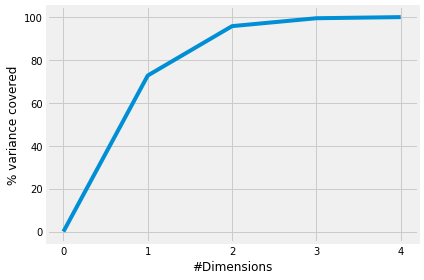

In [22]:
# compute percentage
eig_pairs_percent=[sum(eig_vals[:i+1])/sum(eig_vals)*100 for i,(pair1,pair2) in enumerate(eig_pairs_sorted)]
import matplotlib.pyplot as plt
def plot_pca_variance_covering(percent_lst):
    from matplotlib.ticker import MaxNLocator
    fig,ax=plt.subplots(1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.plot(percent_lst)
    ax.set_xlabel("#Dimensions")
    ax.set_ylabel("% variance covered")
    plt.tight_layout()
    plt.show()
    
# plot the relation of number of dimensions and the accumulated covered variance in percentage
plot_pca_variance_covering([0]+eig_pairs_percent)

If we want to use just as many dimensions as necessary to describe 95 % of the data, then we must compute the accumulated coverage of the Eigenvalues using the sorted Eigenvalues:

In [23]:
# compute min number of dimensions necessary to explain 95% of the data
# first compute all indexes of eigenvalues till 0.95
eig_pairs_min=[i for i,(pair1,pair2) in enumerate(eig_pairs_sorted) if (sum(eig_vals[:i+1])/sum(eig_vals))<0.95]
# then increment the index, so we explain more than 0.95
eig_pairs_min+=[eig_pairs_min[-1]+1] if len(eig_pairs_min)>0 else [0]


# assign all eigenvalue/eigenvector pairs
eig_pairs_reduced=np.array(eig_pairs_sorted)[eig_pairs_min]

Now we can construct the weight vector $W$ using the reduced number of Eigenvalue/Eigenvector pairs:

In [24]:
# create the weight-vector consisting the eigenvectors
W=np.array(eig_pairs_reduced[:,1:].tolist()).reshape((-1,len(eig_pairs_min)))

To get the projected low dimensional space we have to multiply the computed weight vector with the normalized data: $X_{proj}=X_{norm}W$

In [25]:
# create the projected low-dimensional space
X_low=np.dot(X_norm, W)

Plotting the computed low-dimensional space:

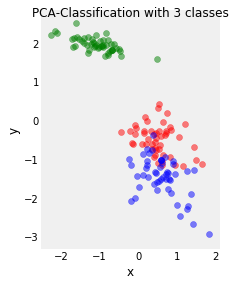

In [26]:
def plot_pca_projection(low_dim_data,Y):
    fig, ax = plt.subplots(1)
    label_dict = {0: 'Class 1', 1: 'Class 2', 2: 'Class 3'}
    colors=["red","green","blue","yellow","black","gray"]

    for label,color in zip(range(0,3),colors):
        y_axis=low_dim_data[:,1] if len(low_dim_data.shape)>1 else None
        ax.scatter(x=low_dim_data[:, 0].real[Y == label],
                    y=y_axis.real[Y == label],
                    color=color,
                    alpha=0.5,
                    label=label_dict[label]
                    )
        # hide grid lines
        ax.grid(b=False)
        plt.xlabel("x")
        plt.ylabel("y")
        ax.set_aspect('equal', adjustable='box')


    fig.suptitle('PCA-Classification with 3 classes')
    plt.tight_layout()

    plt.show()
    
plot_pca_projection(X_low,Y)

To reconstruct the original data using different number of principal components and computing the NRMSE (Normalized Root Mean Squared Error) for each case and normalizing the RMSE by the mean of the input data: $NRMSE_{i}=\frac{RMSE}{\bar{X_{i}}}=\sqrt{\frac{X_{i}-Y_{i}}{\bar{X_{i}}}}$, where $i$ is the index of the feature. 
We can see that the more components we use the less the NRMSE becomes.

In [28]:
# compute NRMSE for different numbers of principal components
for i in range(1, 5):
    # computing the weight vector with different number i of Principal Components
    eig_pairs_reduced = np.array(eig_pairs_sorted)[:i]
    W = np.array(eig_pairs_reduced[:, 1:].tolist()).reshape((4, i))

    # project to low dimensional space
    X_low = np.dot(X_norm, W)

    # reconstruct to original (normalized) space
    X_reconstr = np.dot(X_low, W.T)

    # computing NRMSE
    nrmse = np.sqrt(np.mean(X_norm - X_reconstr, 0) ** 2 / np.mean(X, 0) ** 2)
    if i==1:
        print("NRMSE by using different number of principal components:")
        print("#comp |      x₁     |      x₂     |      x₃     |      x₄      ")
        print("_______________________________________________________________")
    print("   ",i,"|   ", np.format_float_scientific(nrmse[0], unique=False, precision=2),"|",
          np.format_float_scientific(nrmse[1], unique=False, precision=2),"   |",
          np.format_float_scientific(nrmse[2], unique=False, precision=2),"   |",
          np.format_float_scientific(nrmse[3], unique=False, precision=2))

NRMSE by using different number of principal components:
#comp |      x₁     |      x₂     |      x₃     |      x₄      
_______________________________________________________________
    1 |    1.81e-07 | 5.62e-08    | 1.88e-07    | 6.72e-08
    2 |    1.37e-07 | 2.45e-07    | 9.96e-08    | 1.14e-08
    3 |    1.98e-08 | 5.77e-07    | 1.14e-07    | 4.91e-07
    4 |    7.12e-19 | 1.94e-18    | 2.14e-18    | 1.32e-18
